In [53]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx 
import optax
import matplotlib.pyplot as plt

In [54]:
!wget https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_train.npz
!wget https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_test.npz

--2024-09-11 09:15:27--  https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_train.npz
Resolving github.com (github.com)... 20.201.28.151
Connecting to github.com (github.com)|20.201.28.151|:443... connected.
HTTP request sent, awaiting response... 

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


302 Found
Location: https://raw.githubusercontent.com/mroberto166/CAMLab-DLSCTutorials/main/antiderivative_aligned_train.npz [following]
--2024-09-11 09:15:28--  https://raw.githubusercontent.com/mroberto166/CAMLab-DLSCTutorials/main/antiderivative_aligned_train.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241573 (236K) [application/octet-stream]
Saving to: ‘antiderivative_aligned_train.npz.2’

antiderivative_alig 100%[===================>] 235.91K  --.-KB/s    in 0.06s   

2024-09-11 09:15:28 (4.09 MB/s) - ‘antiderivative_aligned_train.npz.2’ saved [241573/241573]

--2024-09-11 09:15:28--  https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_test.npz
Resolving github.com (github.com)... 20.201.28.151
Connecting 

In [55]:
dataset_train = jnp.load('antiderivative_aligned_train.npz', allow_pickle = True)
branch_train = dataset_train['X'][0]
trunk_train = dataset_train['X'][1]
target_train = dataset_train['y']

dataset_test = jnp.load('antiderivative_aligned_train.npz', allow_pickle = True)
branch_test = dataset_train['X'][0]
trunk_test = dataset_train['X'][1]
target_test = dataset_train['y']

branch_train.shape, trunk_train.shape, target_train.shape

((150, 100), (100, 1), (150, 100))

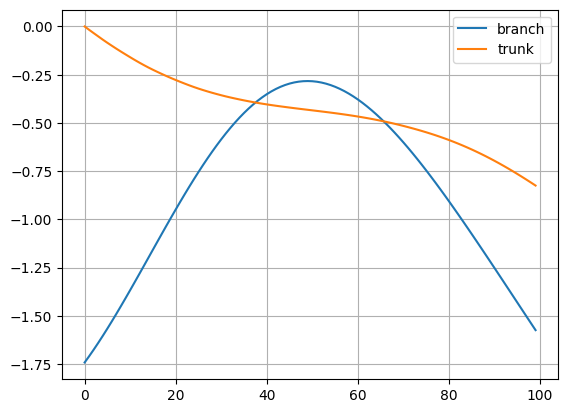

In [56]:
i = 4
plt.plot(branch_train[i, :], label = 'branch')
plt.plot(target_train[i, :], label = 'trunk')
plt.grid()
plt.legend()

In [57]:
class DeepONet(eqx.Module):

    branch__net: eqx.nn.MLP
    trunk__net: eqx.nn.MLP
    bias: jax.Array

    def __init__(
            self,
            input_branch,
            neurons,
            num_layers,
            interact_size,
            activation,
            *,
            key
    ):
        
        b_key, t_key = jr.split(key)
        self.branch__net = eqx.nn.MLP(
            in_size = input_branch,
            out_size = interact_size,
            width_size = neurons,
            depth = num_layers,
            activation = activation,
            key = b_key,
        )
        self.trunk__net = eqx.nn.MLP(
            in_size = 1,
            out_size = interact_size,
            width_size = neurons,
            depth = num_layers,
            activation = activation,
            key = t_key,
        )
        self.bias = jnp.zeros((1,))

    def __call__(
            self,
            x_branch,
            x_trunk
    ):
        out_b = self.branch__net(x_branch)
        out_t = self.trunk__net(x_trunk)
        inner_prod = jnp.sum(out_b * out_t, keepdims=True)

        return (inner_prod + self.bias)[0]

In [58]:
antiderivative_operator = DeepONet(
    input_branch = 100,
    neurons = 40,
    num_layers = 1,
    interact_size = 40,
    activation = jax.nn.relu,
    key = jr.PRNGKey(0),
)

optim = optax.adam(1e-3)
state = optim.init(
    eqx.filter(antiderivative_operator, eqx.is_array)
)

def loss_fn(model):

    pred = jax.vmap(
        jax.vmap(
            model,
            in_axes=(None, 0)
        ),
        in_axes=(0, None)
    )(branch_train, trunk_train)

    mse = jnp.mean(jnp.square(pred - target_train))
    return mse

@eqx.filter_jit
def update_fn(model, state):

    loss, grad = eqx.filter_value_and_grad(loss_fn)(model)
    updates, new_states = optim.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)

    return new_model, new_states, loss

loss_history = []
epochs = 10000
for ep in range(epochs):

    antiderivative_operator, state, loss = update_fn(
        antiderivative_operator,
        state,
    )
    loss_history.append(loss)

    if ep % 1000 == 0: 
        print(f'Iteration: {ep}/{epochs}    Loss: {loss}')

    

Iteration: 0/10000    Loss: 0.5345184206962585
Iteration: 1000/10000    Loss: 6.080688035581261e-05
Iteration: 2000/10000    Loss: 3.2045445550465956e-05
Iteration: 3000/10000    Loss: 2.7755811970564537e-05
Iteration: 4000/10000    Loss: 1.6712019714759663e-05
Iteration: 5000/10000    Loss: 1.5210681340249721e-05
Iteration: 6000/10000    Loss: 9.257747478841338e-06
Iteration: 7000/10000    Loss: 7.247429948620265e-06
Iteration: 8000/10000    Loss: 5.941109520790633e-06
Iteration: 9000/10000    Loss: 0.00010913804726442322


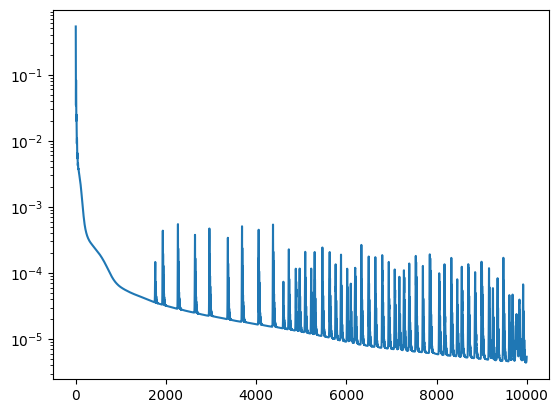

In [59]:
plt.plot(loss_history)
plt.yscale('log')

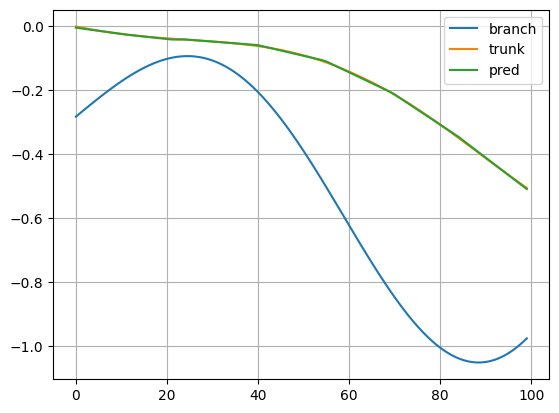

In [66]:
i = 3
plt.plot(
    branch_test[i, :],
    label = 'branch'
)
plt.plot(
    target_test[i, :],
    label = 'trunk'
)
plt.plot(
    jax.vmap(
        antiderivative_operator,
        in_axes = (None, 0)
    )(branch_test[i, :], trunk_test),
    label = 'pred'
)
plt.grid()
plt.legend()